# Imports

In [1]:
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.drift_detection import ADWIN
from skmultiflow.evaluation import EvaluatePrequential
from skmultiflow.data import FileStream
from skmultiflow.metrics import ConfusionMatrix
from skmultiflow.core import Pipeline
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from collections import Counter
import pandas as pd
import numpy as np
from sklearn import tree
import graphviz
%matplotlib notebook

In [62]:
df = pd.read_csv('final_dataset.csv')

X = df.drop(['Label'], axis=1).to_numpy()
y = df['Label'].to_numpy()

#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.under_sampling import NearMiss

#X_nearmiss, y_nearmiss = NearMiss().fit_sample(X, y)

#df = pd.concat([pd.DataFrame(X_nearmiss, columns=X.columns), pd.Series(y_nearmiss, name='Label')], axis=1)

#df = df.sample(frac=1, random_state=1).reset_index(drop=True)

#df.to_csv('labeled_data_balanced.csv', index=False, header=True)

# Hoeffding Trees

## Original data set (unbalanced 10%)

### W/ Subdom levels feature

In [2]:
stream_sd = FileStream('labeled_data.csv')

ht_sd = HoeffdingTreeClassifier()


correctness_dist = []
nb_iters = 50000

evaluator=EvaluatePrequential(show_plot=True,
                              max_samples=nb_iters,
                             metrics=['accuracy', 'recall', 'precision', 'f1', 'kappa'])

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(nb_iters)):
    X, Y = stream_sd.next_sample()        # get the next sample
    prediction = ht_sd.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
    ht_sd.partial_fit(X, Y)             # update the tree

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:17<00:00, 2878.03it/s]


#### Evaluator

<IPython.core.display.Javascript object>


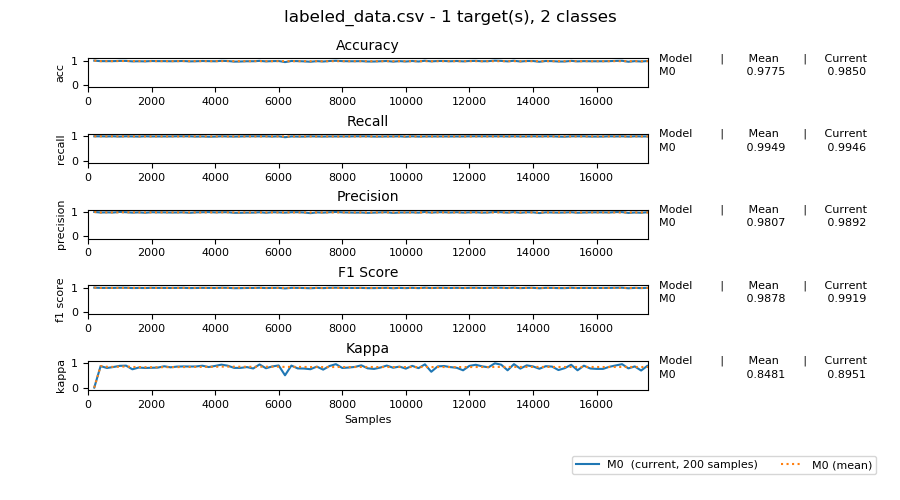

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [9.27s]
Processed samples: 17616
Mean performance:
M0 - Accuracy     : 0.9775
M0 - Kappa        : 0.8481
M0 - Precision: 0.9807
M0 - Recall: 0.9949
M0 - F1 score: 0.9878


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [3]:
%matplotlib notebook
evaluator.evaluate(stream=stream_sd, model=ht_sd)

#### Unlabeled

In [3]:
stream_unlab = FileStream('unlabeled_data.csv')

predictions_sd = []

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(len(pd.read_csv('unlabeled_data.csv')))):
    X, Y = stream_unlab.next_sample()        # get the next sample
    y_pred = ht_sd.predict(X)       # predict Y using the tree     
    predictions.append(y_pred[0])   
    ht_sd.partial_fit(X, y_pred)             # update the tree

100%|████████████████████████████████████████████████████████████████████████| 365383/365383 [01:53<00:00, 3227.29it/s]


In [11]:
predictions_sd = pd.Series(predictions_sd, name='Labeled with subdomains')

### W/O subdom levels feature

In [10]:
# 1. Create a stream
stream_nosd = FileStream('labeled_data_nosubdomlvls.csv')

# 2. Instantiate the HoeffdingTreeClassifier
ht_nosd = HoeffdingTreeClassifier()


correctness_dist = []
nb_iters = 50000

evaluator=EvaluatePrequential(show_plot=True,
                              max_samples=nb_iters,
                             metrics=['accuracy', 'recall', 'precision', 'f1', 'kappa'])

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(nb_iters)):
    X, Y = stream_nosd.next_sample()        # get the next sample
    prediction = ht_nosd.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
    ht_nosd.partial_fit(X, Y)             # update the tree

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:17<00:00, 2910.17it/s]


#### Evalator

<IPython.core.display.Javascript object>


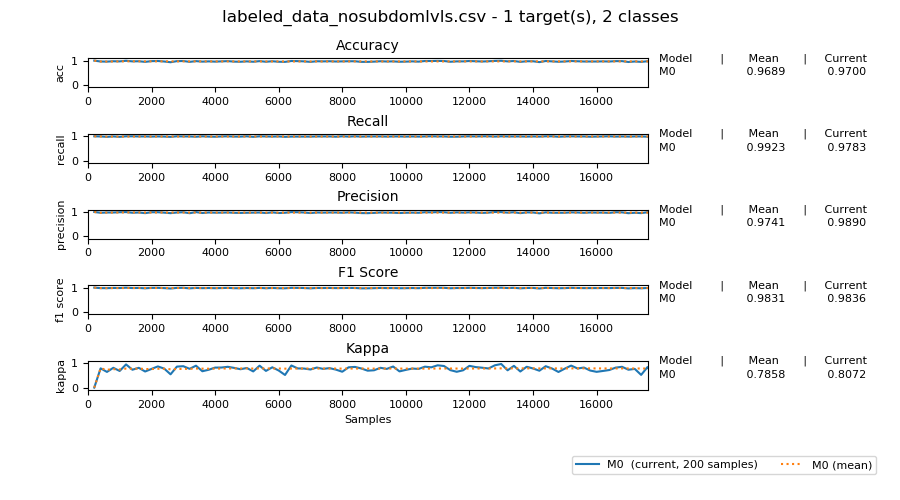

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [9.36s]
Processed samples: 17616
Mean performance:
M0 - Accuracy     : 0.9689
M0 - Kappa        : 0.7858
M0 - Precision: 0.9741
M0 - Recall: 0.9923
M0 - F1 score: 0.9831


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [55]:
%matplotlib notebook
evaluator.evaluate(stream=stream_nosd, model=ht_nosd)

#### Unlabeled

In [12]:
stream_unlab_nosd = FileStream('unlabeled_data_nosubdomlvls.csv')

predictions_nosd = []

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(len(pd.read_csv('unlabeled_data_nosubdomlvls.csv')))):
    X, Y = stream_unlab_nosd.next_sample()        # get the next sample
    y_pred = ht_nosd.predict(X)       # predict Y using the tree     
    predictions_nosd.append(y_pred[0])   
    ht_nosd.partial_fit(X, y_pred)             # update the tree

100%|████████████████████████████████████████████████████████████████████████| 365383/365383 [01:50<00:00, 3318.00it/s]


In [13]:
predictions_nosd = pd.Series(predictions_nosd, name='Labeled w/o subdomains')

In [14]:
ul = pd.read_csv('final_unlabeled.csv')['Domain']
df = pd.concat([pd.Series(ul, name='Domain'), predictions_sd, predictions_nosd], axis=1)

In [15]:
df.to_csv('unlabeled_predictions.csv', index=False, header=True)

## Unbalanced 25%

### W/ Subdom levels feature

In [16]:
# 1. Create a stream
stream = FileStream('labeled_data_25.csv')

# 2. Instantiate the HoeffdingTreeClassifier
ht = HoeffdingTreeClassifier()


correctness_dist = []
nb_iters = 20000
evaluator=EvaluatePrequential(show_plot=True,
                              max_samples=nb_iters,
                             metrics=['accuracy', 'recall', 'precision', 'f1', 'kappa'])
getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(nb_iters)):
    X, Y = stream.next_sample()        # get the next sample
    prediction = ht.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
    ht.partial_fit(X, Y)             # update the tree

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:05<00:00, 3443.73it/s]


#### Evaluator

<IPython.core.display.Javascript object>


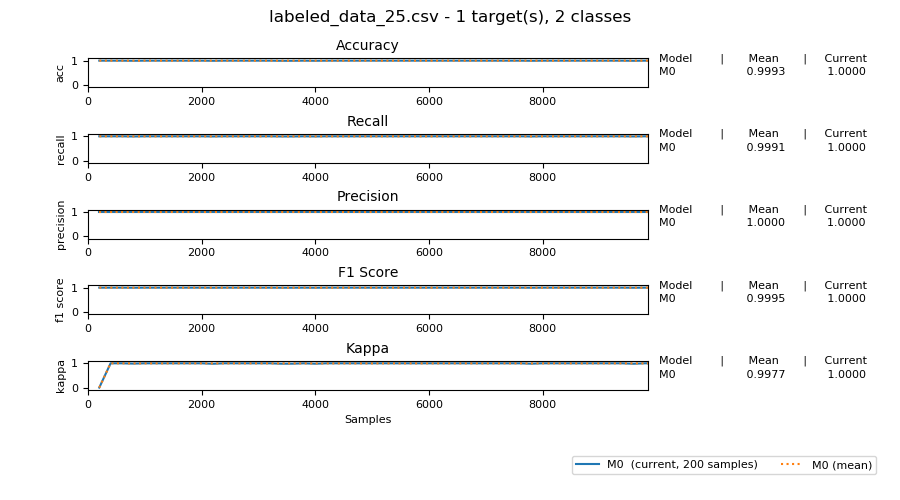

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [4.82s][75%] [3.48s]
Processed samples: 9855
Mean performance:
M0 - Accuracy     : 0.9993
M0 - Kappa        : 0.9977
M0 - Precision: 1.0000
M0 - Recall: 0.9991
M0 - F1 score: 0.9995


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [17]:
%matplotlib notebook
evaluator.evaluate(stream=stream, model=ht)

### W/O subdom levels feature

In [19]:
# 1. Create a stream
stream = FileStream('labeled_data_25_nosubdomlvls.csv')

# 2. Instantiate the HoeffdingTreeClassifier
ht = HoeffdingTreeClassifier()


correctness_dist = []
nb_iters = 20000
evaluator=EvaluatePrequential(show_plot=True,
                              max_samples=nb_iters,
                             metrics=['accuracy', 'recall', 'precision', 'f1', 'kappa'])
getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(nb_iters)):
    X, Y = stream.next_sample()        # get the next sample
    prediction = ht.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
    ht.partial_fit(X, Y)             # update the tree

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:07<00:00, 2700.24it/s]


#### Evalator

<IPython.core.display.Javascript object>


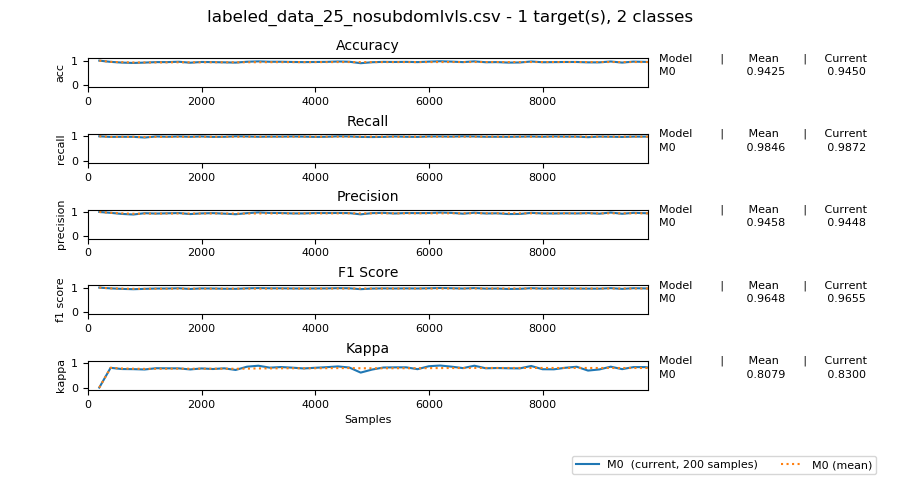

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [5.66s]35%] [1.78s]
Processed samples: 9855
Mean performance:
M0 - Accuracy     : 0.9425
M0 - Kappa        : 0.8079
M0 - Precision: 0.9458
M0 - Recall: 0.9846
M0 - F1 score: 0.9648


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [20]:
%matplotlib notebook
evaluator.evaluate(stream=stream, model=ht)

## Balanced data set

### W/ Subdom levels feature

In [21]:
# 1. Create a stream
stream = FileStream('labeled_data_balanced.csv')

# 2. Instantiate the HoeffdingTreeClassifier
ht = HoeffdingTreeClassifier()


correctness_dist = []
nb_iters = 10000
evaluator=EvaluatePrequential(show_plot=True,
                              max_samples=nb_iters,
                             metrics=['accuracy', 'recall', 'precision', 'f1', 'kappa'])
getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(nb_iters)):
    X, Y = stream.next_sample()        # get the next sample
    prediction = ht.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
    ht.partial_fit(X, Y)             # update the tree

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3306.59it/s]


#### Evaluator

<IPython.core.display.Javascript object>


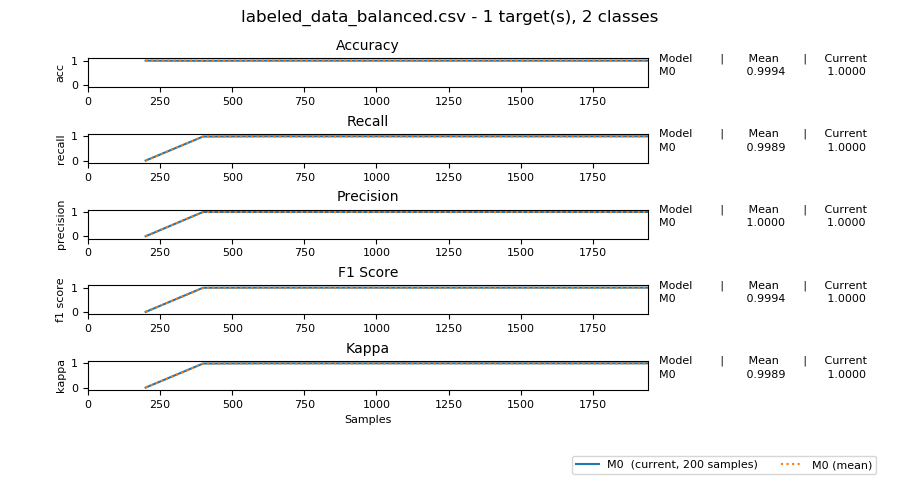

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [0.98s]
Processed samples: 1942
Mean performance:
M0 - Accuracy     : 0.9994
M0 - Kappa        : 0.9989
M0 - Precision: 1.0000
M0 - Recall: 0.9989
M0 - F1 score: 0.9994


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [22]:
%matplotlib notebook
evaluator.evaluate(stream=stream, model=ht)

### W/O subdom levels feature

In [23]:
# 1. Create a stream
stream = FileStream('labeled_data_balanced_nosubdomlvls.csv')

# 2. Instantiate the HoeffdingTreeClassifier
ht = HoeffdingTreeClassifier()


correctness_dist = []
nb_iters = 10000
evaluator=EvaluatePrequential(show_plot=True,
                              max_samples=nb_iters,
                             metrics=['accuracy', 'recall', 'precision', 'f1', 'kappa'])
getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(nb_iters)):
    X, Y = stream.next_sample()        # get the next sample
    prediction = ht.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
    ht.partial_fit(X, Y)             # update the tree

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2555.09it/s]


#### Evaluator

<IPython.core.display.Javascript object>


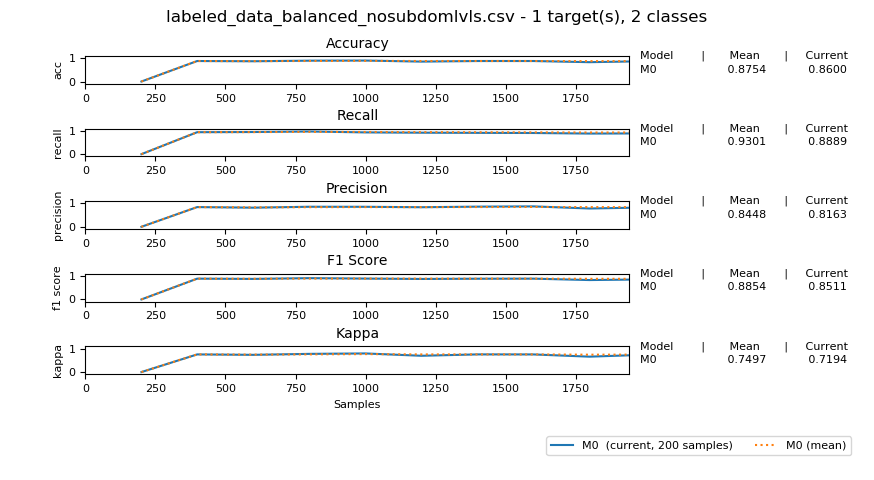

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [1.19s]
Processed samples: 1942
Mean performance:
M0 - Accuracy     : 0.8754
M0 - Kappa        : 0.7497
M0 - Precision: 0.8448
M0 - Recall: 0.9301
M0 - F1 score: 0.8854


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [24]:
%matplotlib notebook
evaluator.evaluate(stream=stream, model=ht)